### SEGMENT ANYTHING MODEL (META)

https://huggingface.co/facebook/sam-vit-base

**IMPORTS**

In [1]:
# system
import sys
import os

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '../../..')))

from config.path import get_training_data_path, get_checkpoint_path, DATASET_PATH_TYPE
from src.utils.augmentation import erase_generator
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np
import torch

from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor

import cv2
import supervision as sv

**INSTALLS**

In [2]:
# %pip install -q 'git+https://github.com/facebookresearch/segment-anything.git'
# %pip install -q jupyter_bbox_widget roboflow dataclasses-json supervision
# !wget -q https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth -P ./weights

In [3]:
CHECKPOINT_PATH = get_checkpoint_path("sam_vit_h_4b8939.pth")
DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
MODEL_TYPE = "vit_h"

https://github.com/facebookresearch/segment-anything/blob/main/segment_anything/automatic_mask_generator.py

In [4]:
sam = sam_model_registry[MODEL_TYPE](checkpoint=CHECKPOINT_PATH).to(device=DEVICE)
mask_generator = SamAutomaticMaskGenerator(
    model=sam,
    points_per_side=5,
    pred_iou_thresh=0.9,
    stability_score_thresh=0.9,
    crop_n_layers=1,
    crop_n_points_downscale_factor=2,
    min_mask_region_area=100,  # Requires open-cv to run post-processing
)

In [5]:
def remove_shadow_rgb(image):
    # Convert image to RGB if it isn't already
    rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) if image.shape[-1] == 3 else image
    # Convert to YCrCb color space
    ycrcb = cv2.cvtColor(rgb, cv2.COLOR_RGB2YCrCb)
    # Split into channels
    y, cr, cb = cv2.split(ycrcb)
    # Apply histogram equalization on the brightness channel
    y_eq = cv2.equalizeHist(y)
    # Merge back the channels
    ycrcb_eq = cv2.merge((y_eq, cr, cb))
    # Convert back to RGB
    result = cv2.cvtColor(ycrcb_eq, cv2.COLOR_YCrCb2RGB)
    return result

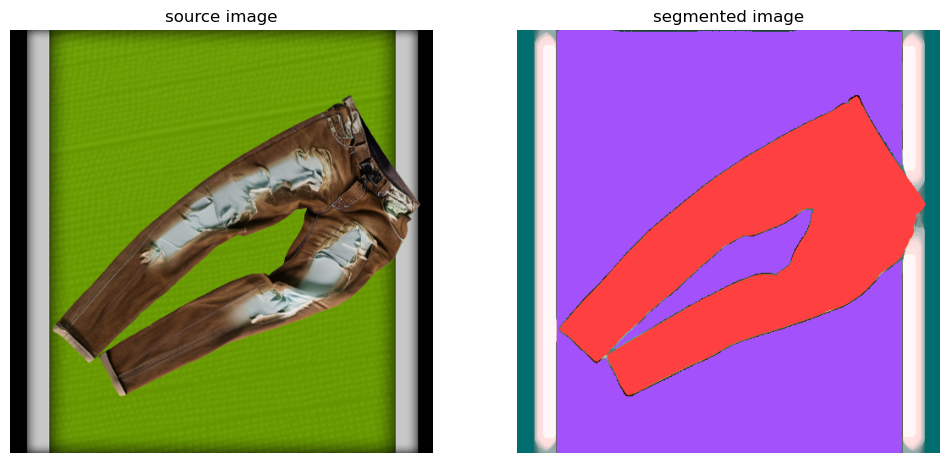

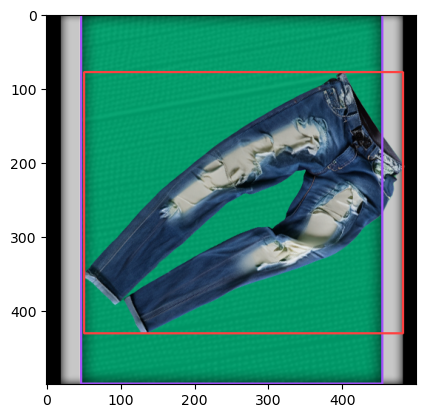

In [74]:
import cv2
import numpy as np

relative_path = get_training_data_path('production', 'pant')

file_names = []

# Walk through all files and directories recursively
for root, dirs, files in os.walk(relative_path):

    # Iterate over files in the current directory
    for i in range(20, 21):
        fullpath = os.path.join(relative_path, '20240527_183622.png')

        orig_image = Image.open(fullpath)
        orig_image = orig_image.rotate(0)
        #image = erase_generator(path=fullpath)
        n_image = np.array(orig_image)
        # Convert image to YCrCb color space, then apply blurring and shadow removal
        image_ycrcb = cv2.cvtColor(n_image, cv2.COLOR_BGR2YCrCb)


        blurred_image = cv2.medianBlur(image_ycrcb, 25)
        processed_image = remove_shadow_rgb(blurred_image)  # Assuming remove_shadow_rgb can handle YCrCb images

        # Generate masks and filter them
        masks = mask_generator.generate(image_ycrcb)
        cleaned_masks = [mask for mask in masks if mask['area'] > 25000]

        # Annotation of the image
        mask_annotator = sv.MaskAnnotator(color_lookup=sv.ColorLookup.INDEX, opacity=1.0)
        detections = sv.Detections.from_sam(sam_result=cleaned_masks)
        annotated_image = mask_annotator.annotate(scene=processed_image.copy(), detections=detections)
        
        # Displaying images
        sv.plot_images_grid(
            images=[n_image, annotated_image],
            grid_size=(1, 2),
            titles=['source image', 'segmented image']
        )

        # Bounding box annotation on the original image for consistency
        bounding_box_annotator = sv.BoundingBoxAnnotator(color_lookup=sv.ColorLookup.INDEX)
        final_annotated_image = bounding_box_annotator.annotate(
            scene=orig_image, detections=detections)

        plt.imshow(final_annotated_image)

In [55]:
def calculate_deviation_from_vertical(north, south):
    # Calculate the direction vector of the line connecting north and south
    vector = np.array(south) - np.array(north)
    
    # Calculate the angle of this vector with respect to the vertical axis
    angle_radians = np.arctan2(vector[0], vector[1])  # Use arctan2 to get the angle in radians
    angle_degrees = np.degrees(angle_radians)
    
    # The angle with respect to the vertical axis (90 degrees)
    deviation_from_vertical = 90 - np.abs(angle_degrees)
    
    return deviation_from_vertical

def calculate_deviation_from_horizontal(west, east):
    # Calculate the direction vector of the line connecting west and east
    vector = np.array(east) - np.array(west)
    
    # Calculate the angle of this vector with respect to the horizontal axis
    angle_radians = np.arctan2(vector[1], vector[0])  # Use arctan2 to get the angle in radians
    angle_degrees = np.degrees(angle_radians)
    
    # The angle with respect to the horizontal axis (0 degrees)
    deviation_from_horizontal = np.abs(angle_degrees)
    
    return deviation_from_horizontal

ANG ANG
146.24421057548614


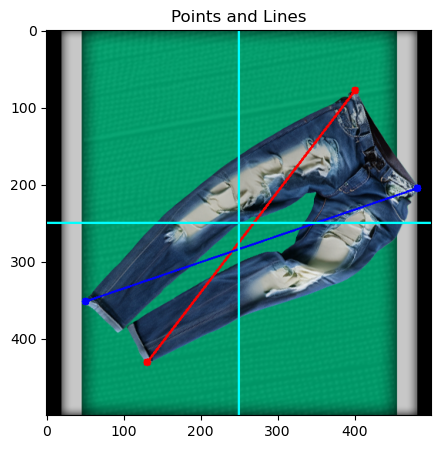

Deviation from vertical: -217.41 degrees
Deviation from horizontal: 108.83 degrees


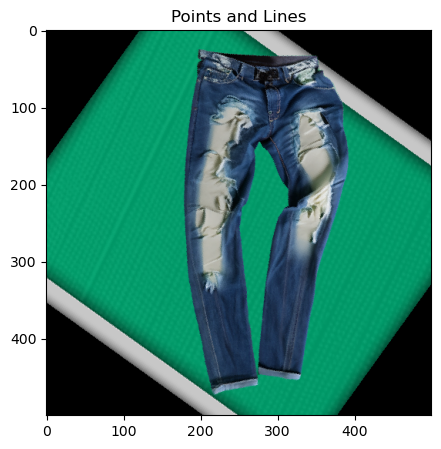

In [75]:

def plot_points(image, points, color=(0, 255, 0), radius=5):
    image = np.asarray(image)
    colors = [
        (255, 0, 0), # north
        (255, 0, 0), # south
        (0, 0, 255), # east
        (0, 0, 255), # west
    ]

    for i, point in enumerate(points):
        cv2.circle(image, (point[1], point[0]), radius, colors[i], -1)
    
    cv2.line(image, (north[1], north[0]), (south[1], south[0]), (255, 0, 0), 2) # predicted vertical line
    cv2.line(image, (west[1], west[0]), (east[1], east[0]), (0, 0, 255), 2) # predicted horizontal line
    cv2.line(image, (250, 0), (250, 500), (0, 255, 255), 2) # vertical line
    cv2.line(image, (0, 250), (500, 250), (0, 255, 255), 2) # horizontal line

    plt.figure(figsize=(5, 5))
    plt.imshow(image)
    plt.title("Points and Lines")
    plt.show()
    return image

def calculate_angle_between_lines(line1_point1, line1_point2, line2_point1, line2_point2):
    # Calculate direction vectors of the lines
    vector1 = np.array(line1_point2) - np.array(line1_point1)
    vector2 = np.array(line2_point2) - np.array(line2_point1)
    
    # Normalize the vectors
    unit_vector1 = vector1 / np.linalg.norm(vector1)
    unit_vector2 = vector2 / np.linalg.norm(vector2)
    
    # Calculate the dot product of the normalized vectors
    dot_product = np.dot(unit_vector1, unit_vector2)
    
    # Ensure the dot product is within the valid range for arccos to avoid NaN errors due to floating-point precision issues
    dot_product = np.clip(dot_product, -1.0, 1.0)
    
    # Calculate the angle in radians
    angle_radians = np.arccos(dot_product)
    
    # Convert the angle to degrees
    angle_degrees = np.degrees(angle_radians)
    
    return angle_degrees

# Assume cleaned_masks and orig_image are defined elsewhere
mask = cleaned_masks[0]['segmentation']
bbox = cleaned_masks[0]['bbox']

if (bbox[1] + bbox[3] <= 490) and (bbox[1] >= 5):

    coords = np.column_stack(np.where(mask))

    north = coords[np.argmin(coords[:, 0])]
    south = coords[np.argmax(coords[:, 0])]
    west = coords[np.argmin(coords[:, 1])]
    east = coords[np.argmax(coords[:, 1])]

    print("ANG ANG")
    ang = calculate_angle_between_lines(north, south, west, east)
    print(ang)
    plot_points(orig_image, [north, south, west, east])
    
    deviation_v = calculate_deviation_from_vertical(north, south)

    if deviation_v < 0:
        deviation_v = -180 + deviation_v
    
    
    print(f"Deviation from vertical: {deviation_v:.2f} degrees")
    
    deviation_h = calculate_deviation_from_horizontal(west, east)
    print(f"Deviation from horizontal: {deviation_h:.2f} degrees")

    totla = (deviation_v + deviation_h) / 2

    img_rot = orig_image.rotate(-totla)

    plt.figure(figsize=(5, 5))
    plt.imshow(img_rot)
    plt.title("Points and Lines")
    plt.show()

else: 
    print('Object not fully visible... awaiting position change')

2
65363


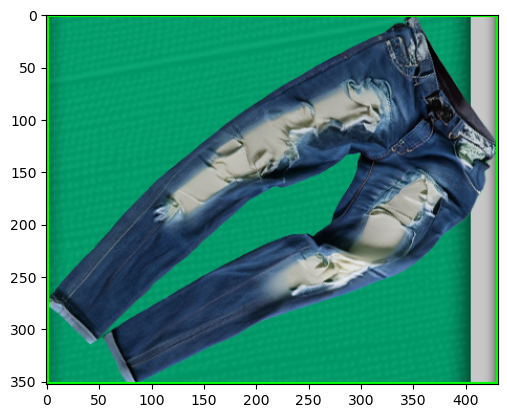

In [76]:
masks_cleaned = []
print(len(masks))
for mask in masks: 
    if np.mean(mask['segmentation'][3]) <= 0.2 and (mask['area'] >= 25000 and mask['area'] <= 200000):
        print(mask['area'])
        masks_cleaned.append(mask)

masked_image = n_image
x, y, w, h = cleaned_masks[0]['bbox']
cv2.rectangle(masked_image, (x, y), (x + w, y + h), (0, 255,0), 3)
cropped_image = masked_image[y:y+h, x:x+w]


plt.imshow(cropped_image)